In [1]:
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotly.express as px
import json

import plotly.io as pio
import re
from sklearn.linear_model import LinearRegression

pio.templates.default = "plotly_dark"
pio.renderers.default = "browser"

In [2]:
def get_salary_cap_events():
    ## Load json file from downloads
    with open('C:/Users/jrnas/Downloads/BBGM_League_1_2220_free_agency(1).json', encoding='latin') as f:
        r_json = json.load(f)

    return pd.DataFrame([(x['season'], x['text']) for x in r_json['events'] if 'An inflation rate of' in x['text']],
                        columns=['season', 'text'])


def extract_values(text):
    # Pattern for inflation rate
    inflation_pattern = r"(\d+(\.\d+)?)%"
    # Pattern for salary cap
    salary_cap_pattern = r"\$(\d+(\.\d+)?[MB]?)"

    # Search for the patterns
    inflation_match = re.search(inflation_pattern, text)
    salary_cap_match = re.search(salary_cap_pattern, text)

    # Extract the matched values
    inflation_rate = float(inflation_match.group(1)) if inflation_match else None
    salary_cap = salary_cap_match.group(1) if salary_cap_match else None

    return inflation_rate, salary_cap


def convert_salary_cap(salary_cap):
    if salary_cap.endswith('M'):
        return float(salary_cap[:-1])
    elif salary_cap.endswith('B'):
        return float(salary_cap[:-1]) * 1000
    else:
        return None


def get_salary_cap():
    inf_df = get_salary_cap_events()
    inf_df['inf_rate'], inf_df['salary_cap'] = zip(*inf_df['text'].apply(extract_values))
    inf_df['salary_cap'] = inf_df['salary_cap'].apply(convert_salary_cap)
    inf_df = inf_df[['season', 'inf_rate', 'salary_cap']]
    ## Add a row for 2023
    inf_df = pd.concat(
        [pd.DataFrame({'season': 2023, 'inf_rate': 0, 'salary_cap': 136}, index=[0]), inf_df]).reset_index(
        drop=True)
    ## Set up dictionary
    return inf_df.set_index('season').to_dict()['salary_cap']

In [3]:
salary_cap = get_salary_cap()

In [4]:
with open('C:/Users/jrnas/Downloads/BBGM_League_1_2220_free_agency.json', encoding='latin') as f:
    r_json = json.load(f)

In [5]:
# Initialize an empty list to store the data
data = []

# Iterate over the list of players
for player in tqdm(r_json['players']):
    # Iterate over the ratings of the current player
    for rating in player['stats']:
        # Create a new dictionary that includes 'pid', 'firstName', 'lastName' and the rating
        row = {
            'pid': player['pid']
        }
        row.update(rating)
        # Append the dictionary to the list
        data.append(row)

# Convert the list of dictionaries to a DataFrame
stats_df = (
    pd.DataFrame(data)
    .convert_dtypes(dtype_backend='pyarrow')
)

stats_df = stats_df[(stats_df.season.between(2024, 2220)) & (stats_df.playoffs == False)].reset_index(drop=True)

100%|██████████| 14724/14724 [00:00<00:00, 29209.01it/s]


In [6]:
# Initialize an empty list to store the data
data = []

# Iterate over the list of players
for player in tqdm(r_json['players']):
    # Iterate over the ratings of the current player
    for rating in player['ratings']:
        # Create a new dictionary that includes 'pid', 'firstName', 'lastName' and the rating
        row = {
            'pid': player['pid'],
            'firstName': player['firstName'],
            'lastName': player['lastName'],
            'born': player['born']['year'],
        }
        row.update(rating)
        # Append the dictionary to the list
        data.append(row)

# Convert the list of dictionaries to a DataFrame
ratings_df = (
    pd.DataFrame(data)
    .convert_dtypes(dtype_backend='pyarrow')
    .astype({'skills': 'string[pyarrow]'})
    .assign(
        age=lambda x: x.season - x.born,
    )
)

ratings_df = ratings_df[ratings_df.season.between(2024, 2220)].reset_index(drop=True)

100%|██████████| 14724/14724 [00:00<00:00, 72218.76it/s]


In [7]:
# Initialize an empty list to store the data
data = []

# Iterate over the list of players
for player in tqdm(r_json['players']):
    # Iterate over the ratings of the current player
    for rating in player['salaries']:
        # Create a new dictionary that includes 'pid', 'firstName', 'lastName' and the rating
        row = {
            'pid': player['pid'],
        }
        row.update(rating)
        # Append the dictionary to the list
        data.append(row)

# Convert the list of dictionaries to a DataFrame
salaries_df = (
    pd.DataFrame(data)
    .convert_dtypes(dtype_backend='pyarrow')
)

salaries_df = salaries_df[salaries_df.season.between(2024, 2220)].reset_index(drop=True)

100%|██████████| 14724/14724 [00:00<00:00, 391965.65it/s]


In [8]:
df = ratings_df.merge(
    stats_df[['pid', 'season', 'tid', 'gp', 'gs', 'min', 'usgp', 'ortg', 'drtg', 'obpm', 'dbpm', 'ows', 'dws', 'vorp',
              'ewa']],
    on=['pid', 'season'], how='left').merge(
    salaries_df[['pid', 'season', 'amount']].rename(columns={'amount': 'salary'}), on=['pid', 'season'], how='left')

In [9]:
df['vorp_norm'] = (df['vorp'] / df['min']) * (32 * 82)

In [10]:
test_df = df[(df['min'] > 10) & (~df['vorp_norm'].isna())].reset_index(drop=True)
test_df['vorp_norm_wt'] = test_df['vorp_norm'] * test_df['min']
agg_df = test_df.groupby('ovr')[['vorp_norm_wt', 'min']].sum().reset_index()
agg_df['vorp_norm'] = agg_df['vorp_norm_wt'] / agg_df['min']

In [18]:
under_over = 56.064

model_df_under = agg_df[agg_df['ovr'] <= under_over].reset_index(drop=True)
poly_under = np.polyfit(model_df_under['ovr'], model_df_under['vorp_norm'], 1)

model_df_over = agg_df[agg_df['ovr'] > under_over].reset_index(drop=True)
poly_over = np.polyfit(model_df_over['ovr'], model_df_over['vorp_norm'], 1)

df['vorp_under'] = np.polyval(poly_under, df['ovr'])
df['vorp_over'] = np.polyval(poly_over, df['ovr'])
df['vorp_pred'] = np.where(
    df['ovr'] <= under_over,
    df['vorp_under'],
    df['vorp_over']
)

In [56]:
df['cvorp'] = df['vorp'].clip(0, )
df['vorp_pct'] = df['vorp_pred'].clip(0, ) / df.groupby('season').cvorp.sum().mean()
df['vorp_pct_cap'] = df['vorp_pct'] * 30

In [58]:
### Growth

In [59]:
df = df.drop_duplicates(['pid', 'season'], keep='first').reset_index(drop=True)

In [60]:
df['ovr+'] = df.groupby('pid')['ovr'].shift(-1) - df['ovr']

Count: 6828
Mean: 4.160076157000586
Std: 4.615905351267984


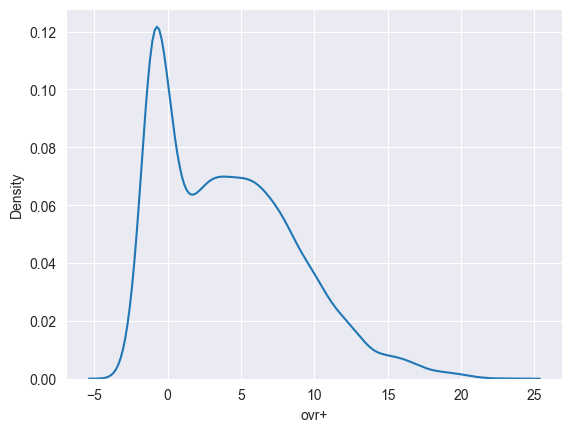

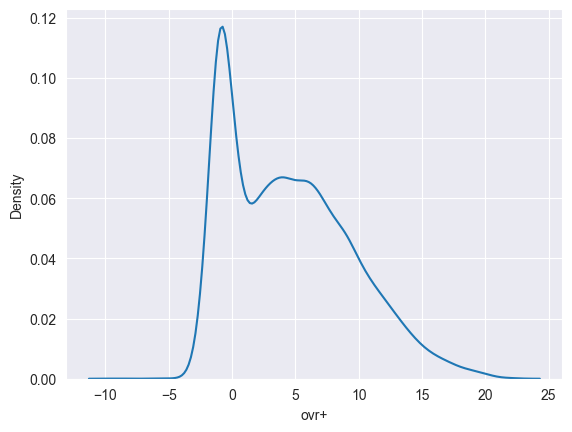

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
age = 19
kde_19 = sns.kdeplot(df[df.age.isin([age, age-1])][['age','ovr','ovr+']].dropna()['ovr+'])
plt.figure()
kde_20 = sns.kdeplot(df[df.age == (age + 1)][['age','ovr','ovr+']].dropna()['ovr+'])
print(f"Count: {df[df.age == age]['ovr+'].count()}")
print(f"Mean: {df[df.age == age]['ovr+'].mean()}")
print(f"Std: {df[df.age == age]['ovr+'].std()}")

In [63]:
x1, y1 = kde_19.get_lines()[0].get_data()

In [64]:
x2, y2 = kde_20.get_lines()[0].get_data()

In [65]:
df[df.age.isin([age, age-1])][['age','ovr','ovr+']].dropna()['ovr+'].mean()

4.162913132494881

In [66]:
df[df.age == age + 1][['age','ovr','ovr+']].dropna()['ovr+'].mean()

4.527957508450024

In [67]:
print(np.dot(x1, y1) / np.sum(y1))
print(np.dot(x2, y2) / np.sum(y2))

4.162914905828783
4.5279536749773905


In [70]:
from scipy.stats import gaussian_kde
kde_dict = dict()

for age in [19,20,21,22]:
    kde_dict[age] = dict()
    kde_dict[age]['data'] = df[df.age == age]['ovr+'].dropna().values
    kde_dict[age]['kde'] = gaussian_kde(kde_dict[age]['data'])
    kde_dict[age]['x'] = np.linspace(-100, 100, 1000)
    kde_dict[age]['density'] = kde_dict[age]['kde'](kde_dict[age]['x'])

In [71]:
from scipy import signal
import numpy as np

def convolve_distributions(kdes):
    # Generate x values that cover the range of all KDEs
    x = np.linspace(-100, 100, 1000)

    # Initialize the convolved density as the density of the first KDE
    y_convolved = kdes[0](x)

    # Iterate over the rest of the KDEs
    for kde in kdes[1:]:
        # Calculate the density of the current KDE
        y = kde(x)

        # Perform the convolution
        y_convolved = signal.convolve(y_convolved, y, mode='same')

        # Normalize the result
        y_convolved /= np.trapz(y_convolved, x)  # Use trapezoidal rule to approximate the integral

    return x, y_convolved

# Use the function with two KDEs from your dictionary
x_new, y_new = convolve_distributions([
    kde_dict[19]['kde'], 
    kde_dict[20]['kde'],
    kde_dict[21]['kde'],
    kde_dict[22]['kde'],
])
# Normalize the result
y_new /= np.trapz(y_new, x_new)  # Use trapezoidal rule to approximate the integral

In [72]:
px.line(
    x=x_new,
    y=y_new,
    title='Convolved Distribution of OVR Growth',
    labels={'x': 'OVR Growth', 'y': 'Density'},
    range_x=[-20, 60]
)

In [73]:
player_rating = 40

In [74]:
x_rating = x_new + player_rating

In [75]:
vorp_under = lin_reg_under.predict(x_rating.reshape(-1, 1))
vorp_over = lin_reg_over.predict(x_rating.reshape(-1, 1))
vorp_pred = np.where(
    x_rating <= under_over,
    vorp_under,
    vorp_over
)

vorp_value = vorp_pred.clip(0, )

C:\Users\jrnas\anaconda3\envs\BBGM\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

C:\Users\jrnas\anaconda3\envs\BBGM\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



In [76]:
pd.DataFrame({'x_rating': x_rating, 'vorp_value': vorp_value})

,x_rating,vorp_value
0,-60.000000,0.000000
1,-59.799800,0.000000
2,-59.599600,0.000000
3,-59.399399,0.000000
4,-59.199199,0.000000
...,...,...
995,139.199199,37.652974
996,139.399399,37.741834
997,139.599600,37.830695
998,139.799800,37.919556


In [77]:
px.line(
    x=vorp_value,
    y=y_new,
    title='Convolved Distribution of OVR Growth',
    labels={'x': 'OVR Growth', 'y': 'Density'},
    range_x=[0, 20]
)